# Define baseline model

With the features that we created, we're going to create two baseline models, one is with a business rule and other is with a simple machine learning model (decision tree). This is to analyse what results we can achieve with these options.

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import yaml


from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from typing import Union
from datetime import datetime,date
from src.data.data_cleaning import make_pipeline,convert_to_date,convert_to_datetime

## 1 - Data reading

In [3]:
df = pd.read_csv("./data/processed/df_loans_with_loans_repays_hist_and_trans_hist_per_user_cleared.csv")
print("df columns:",df.columns)
print("df shape:",df.shape)
df.head()

df columns: Index(['id', 'user_id', 'amount', 'total_amount', 'due_amount', 'due_date',
       'status', 'created_at', 'date_created', 'reference_date',
       'sum_amt_transactions_at_created_loan',
       'sum_amt_payment_method_credit_at_created_loan',
       'sum_amt_payment_method_debit_at_created_loan',
       'sum_amt_transactions_in_visa_at_created_loan',
       'sum_amt_transactions_in_mastercard_at_created_loan',
       'sum_amt_transactions_in_elo_at_created_loan',
       'max_amt_transactions_at_created_loan',
       'max_installments_at_created_loan',
       'median_installments_at_created_loan',
       'most_frequent_transactions_payment_method_at_created_loan',
       'sum_amt_transactions_in_last_month',
       'sum_amt_payment_method_credit_in_last_month',
       'sum_amt_payment_method_debit_in_last_month',
       'sum_amt_transactions_in_visa_in_last_month',
       'sum_amt_transactions_in_mastercard_in_last_month',
       'sum_amt_transactions_in_elo_in_last_month',

,id,user_id,amount,total_amount,due_amount,due_date,status,created_at,date_created,reference_date,...,avg_repaid_total_amt_loans_in_last_six_months,avg_pct_repaid_first_month_loans_in_last_six_months,avg_pct_repaid_sec_month_loans_in_last_six_months,avg_pct_repaid_trd_month_loans_in_last_six_months,max_repaid_total_amt_loans_in_last_six_months,most_frequent_loans_repayment_method_in_last_six_months,pct_repaid_loans_in_last_six_months,time_years,annual_interest_rate,monthly_interest_rate
0,0,3070,6000.0,6045.28,6459.0,2022-05-02,repaid,2022-02-01 00:47:29.575000+00:00,2022-02-01,2022-02-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,30.8,2.26
1,1,2546,6000.0,6045.28,6459.0,2022-05-02,repaid,2022-02-01 00:49:51.763000+00:00,2022-02-01,2022-02-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,30.8,2.26
2,2,2413,6000.0,6045.28,6459.0,2022-05-02,repaid,2022-02-01 01:24:40.537000+00:00,2022-02-01,2022-02-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,30.8,2.26
3,3,2585,6000.0,6045.28,6459.0,2022-05-02,debt,2022-02-01 02:52:59.803000+00:00,2022-02-01,2022-02-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,30.8,2.26
4,4,2556,6000.0,6045.28,6459.0,2022-05-02,repaid,2022-02-01 02:53:07.123000+00:00,2022-02-01,2022-02-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,30.8,2.26


In [4]:
for k,v in df.dtypes.items():
    print(k,":",v)

id : int64
user_id : int64
amount : float64
total_amount : float64
due_amount : float64
due_date : object
status : object
created_at : object
date_created : object
reference_date : object
sum_amt_transactions_at_created_loan : float64
sum_amt_payment_method_credit_at_created_loan : float64
sum_amt_payment_method_debit_at_created_loan : float64
sum_amt_transactions_in_visa_at_created_loan : float64
sum_amt_transactions_in_mastercard_at_created_loan : float64
sum_amt_transactions_in_elo_at_created_loan : float64
max_amt_transactions_at_created_loan : float64
max_installments_at_created_loan : float64
median_installments_at_created_loan : float64
most_frequent_transactions_payment_method_at_created_loan : object
sum_amt_transactions_in_last_month : float64
sum_amt_payment_method_credit_in_last_month : float64
sum_amt_payment_method_debit_in_last_month : float64
sum_amt_transactions_in_visa_in_last_month : float64
sum_amt_transactions_in_mastercard_in_last_month : float64
sum_amt_transacti

In [5]:
## check null values 
for k,v in ((df.isnull().sum())/df.shape[0]).items():
    print(k,":",v)

id : 0.0
user_id : 0.0
amount : 0.0
total_amount : 0.0
due_amount : 0.0
due_date : 0.0
status : 0.0
created_at : 0.0
date_created : 0.0
reference_date : 0.0
sum_amt_transactions_at_created_loan : 0.10836050993181144
sum_amt_payment_method_credit_at_created_loan : 0.12007115327601542
sum_amt_payment_method_debit_at_created_loan : 0.3631781796620219
sum_amt_transactions_in_visa_at_created_loan : 0.18751852949896236
sum_amt_transactions_in_mastercard_at_created_loan : 0.1528313074414468
sum_amt_transactions_in_elo_at_created_loan : 0.40764897717165727
max_amt_transactions_at_created_loan : 0.10836050993181144
max_installments_at_created_loan : 0.10836050993181144
median_installments_at_created_loan : 0.10836050993181144
most_frequent_transactions_payment_method_at_created_loan : 0.10836050993181144
sum_amt_transactions_in_last_month : 0.019863622887637118
sum_amt_payment_method_credit_in_last_month : 0.02164245478802253
sum_amt_payment_method_debit_in_last_month : 0.2434034983694041
sum_a

## 2 - Data preprocessing

Convert to date columns to datetime type.

In [6]:
list_functions = [
    {"function": convert_to_datetime, "function_kwargs": {
        "col_to_convert":"created_at",
        "fmt":"ISO8601"
    }},
    {"function": convert_to_date, "function_kwargs": {
        "col_to_convert":"due_date",
        "fmt":"%Y-%m-%d"
    }},
    {"function": convert_to_date, "function_kwargs": {
        "col_to_convert":"date_created",
        "fmt":"%Y-%m-%d"
    }},
    {"function": convert_to_date, "function_kwargs": {
        "col_to_convert":"reference_date",
        "fmt":"%Y-%m-%d"
    }},
]
df = make_pipeline(dataframe=df,functions=list_functions)

## select only repaid and debt loans
df = df[(df["status"]=="repaid")|(df["status"]=="debt")]

In [7]:
for k,v in df[["created_at","reference_date","due_date","date_created"]].loc[0].items():
    print(k,":",v.__class__)

created_at : <class 'pandas._libs.tslibs.timestamps.Timestamp'>
reference_date : <class 'datetime.date'>
due_date : <class 'datetime.date'>
date_created : <class 'datetime.date'>


In [8]:
# check the date where this loans are created.
year_month_loans_created = pd.Series([f"{d.date().month}/{d.date().year}" for d in pd.to_datetime(df["created_at"],format="ISO8601")])
year_month_loans_created.value_counts(ascending=False)

4/2022     1482
7/2022      957
2/2022      895
6/2022      778
8/2022      728
9/2022      723
3/2022      588
5/2022      535
10/2022      46
Name: count, dtype: int64

## 4 - Create train and test data

In [9]:
TARGET = "status"
NUM_FEATURES = list(df.select_dtypes(include=["float64"],exclude=["object","int64"]).columns)
CAT_FEATURES = [col for col in list(df.select_dtypes(include=["object"],exclude=["float64","int64"]).columns)
                if col not in ["date_created","reference_date","created_at","due_date",TARGET]]
FEATURES = NUM_FEATURES + CAT_FEATURES
FEATURES

['amount',
 'total_amount',
 'due_amount',
 'sum_amt_transactions_at_created_loan',
 'sum_amt_payment_method_credit_at_created_loan',
 'sum_amt_payment_method_debit_at_created_loan',
 'sum_amt_transactions_in_visa_at_created_loan',
 'sum_amt_transactions_in_mastercard_at_created_loan',
 'sum_amt_transactions_in_elo_at_created_loan',
 'max_amt_transactions_at_created_loan',
 'max_installments_at_created_loan',
 'median_installments_at_created_loan',
 'sum_amt_transactions_in_last_month',
 'sum_amt_payment_method_credit_in_last_month',
 'sum_amt_payment_method_debit_in_last_month',
 'sum_amt_transactions_in_visa_in_last_month',
 'sum_amt_transactions_in_mastercard_in_last_month',
 'sum_amt_transactions_in_elo_in_last_month',
 'max_amt_transactions_in_last_month',
 'max_installments_in_last_month',
 'median_installments_in_last_month',
 'avg_amt_transactions_in_last_three_months',
 'avg_amt_payment_method_credit_in_last_three_months',
 'avg_amt_payment_method_debit_in_last_three_months',


In [10]:
train_data = df[df["date_created"].between(left=date(2022,1,1),right=date(2022,9,1),inclusive="left")]
test_data = df[df["date_created"].between(left=date(2022,9,1),right=date(2022,11,1),inclusive="left")]

print("min date_created in train_data: ",train_data["date_created"].min())
print("max date_created in train_data: ",train_data["date_created"].max())
print("min date_created in test_data: ",test_data["date_created"].min())
print("max date_created in test_data: ",test_data["date_created"].max())
print("'%' data in train_data:",(train_data.shape[0]/df.shape[0])*100.0)
print("'%' data in test_data:",(test_data.shape[0]/df.shape[0])*100.0)

min date_created in train_data:  2022-02-01
max date_created in train_data:  2022-08-31
min date_created in test_data:  2022-09-01
max date_created in test_data:  2022-10-03
'%' data in train_data: 88.5769459298871
'%' data in test_data: 11.423054070112894


In [11]:
X_train = train_data[FEATURES]
y_train = train_data[TARGET].map({"repaid":1,"debt":0})
X_test = test_data[FEATURES]
y_test = test_data[TARGET].map({"repaid":1,"debt":0})

print("X_train, y_train shape:",(X_train.shape,y_train.shape))
print("X_test, y_test:",(X_test.shape,y_test.shape))

X_train, y_train shape: ((5963, 69), (5963,))
X_test, y_test: ((769, 69), (769,))


In [12]:
train_data.to_csv("./data/processed/train_data.csv",index=False)
test_data.to_csv("./data/processed/test_data.csv",index=False)

## 5 - Applying business rule

As for our business rule, we're going to assume that loans which a user have a total_amount of loan bigger than the sum of amount of transactions made in the last month before the loan creation date are not repaid. Otherwise, the user is probabily going to repay. 

Remember from EDA that a users when making a loan and not repay tends to have lower spending when they are close to make a loan.

In [13]:
print("Proportion of debt in train data")
y_train.value_counts(normalize=True)

Proportion of debt in train data


status
1    0.741908
0    0.258092
Name: proportion, dtype: float64

In [14]:
heuristic_predict = (
    (X_test["total_amount"]>X_test["sum_amt_transactions_in_last_month"])
).map({False:1,True:0})

heuristic_predict.value_counts(normalize=True)

1    0.862159
0    0.137841
Name: proportion, dtype: float64

In [15]:
print(classification_report(y_test, heuristic_predict, target_names=['debt', 'repaid']))

              precision    recall  f1-score   support

        debt       0.42      0.30      0.35       145
      repaid       0.85      0.90      0.87       624

    accuracy                           0.79       769
   macro avg       0.63      0.60      0.61       769
weighted avg       0.77      0.79      0.77       769



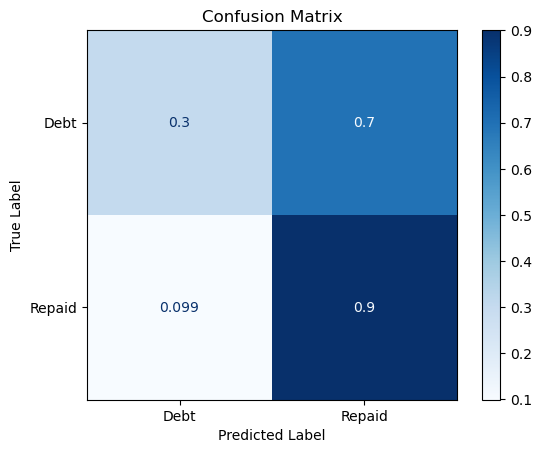

In [16]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, heuristic_predict, normalize='true')

# Define the class labels
labels = ['Debt', "Repaid"]  # Replace with your class labels

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The model with only business rules presented a strong bias towards loans as repaid. As a result of our dataset also being unbalanced, just using a single business rule does not seem to be enough to define churn, so an ML approach seems to be a better solution.

## 6 - Decision Tree

Let's create a decision tree to generate loan predictions. The decision tree is known for being a non-linear model that builds a decision tree in which the classification rules are defined through the information gain of a feature. It is known for a simple and intuitive model, we can visualize the classification rules, which makes them well explainable models. Let's evaluate how well it can predict churn in our dataset.

In [17]:
# Define the pipeline
# Create the column transformer

categorical_transformer = Pipeline(
    steps=[
        ('cat_imputer',SimpleImputer(strategy="most_frequent")),
        ('ohe_cat', OneHotEncoder())
        ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='constant',fill_value=0), NUM_FEATURES),
        ('cat', categorical_transformer, CAT_FEATURES)])

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (imputation + one-hot encoding)
    ('model', DecisionTreeClassifier(class_weight='balanced',random_state=42))  # Model
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['amount', 'total_amount',
                                                   'due_amount',
                                                   'sum_amt_transactions_at_created_loan',
                                                   'sum_amt_payment_method_credit_at_created_loan',
                                                   'sum_amt_payment_method_debit_at_created_loan',
                                                   'sum_amt_transactions_in_visa_at_created_loan',
                                                   'sum_amt_tra...
                                                   'most_frequent_transactions_payment_method_in_last_three_months',
                                                   'most_frequent_transactions_payment_method_in_last_six_months',
                                                   'most_frequent_loans_repayment_method_in_last_month',
                                                   'most_frequent_loans_repayment_method_in_last_three_months',
                                                   'most_frequent_loans_repayment_method_in_last_six_months'])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [18]:
y_pred_class = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

print(classification_report(y_test, y_pred_class,target_names=['debt', 'repaid']))

              precision    recall  f1-score   support

        debt       0.31      0.32      0.32       145
      repaid       0.84      0.83      0.84       624

    accuracy                           0.74       769
   macro avg       0.58      0.58      0.58       769
weighted avg       0.74      0.74      0.74       769



In [19]:
print("Proportion of debt and repaid:")
cat,ncat = np.unique(y_pred_class,return_counts=True)
for cat, qty in zip(cat,ncat):
    print(f"{cat}:{qty/np.sum(ncat,axis=0)}")

Proportion of debt and repaid:
0:0.19505851755526657
1:0.8049414824447334


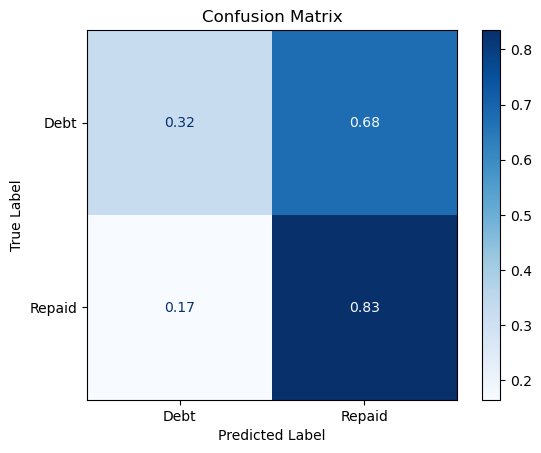

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_class, normalize='true')

# Define the class labels
labels = ['Debt', "Repaid"]  # Replace with your class labels

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The decision tree have a performance similar to the business rule but with the same problem. The model have a strong bias to classify a loan as repaid, but we can see that its better at classify debt and the false positives have reduce in comparison with the business rule.

## 7 - Save configs

In [21]:
OUTPUT_PATH = Path("./config")

model_name = "decision_tree_clf_for_loan_repaymnt_pred"

num_features = [str.encode(col,encoding="ISO-8859-1") for col in NUM_FEATURES]
cat_features = [str.encode(col,encoding="ISO-8859-1") for col in CAT_FEATURES]

fit_model_params = pipeline.named_steps["model"].get_params()

MODEL_PARAMETERS = {
    "model_name":model_name,
    "model_version":1,
    "model_parameters":{
        "fit_params":fit_model_params
        },
    "model_features":{"NUM_FEATURES":num_features,"CAT_FEATURES":cat_features},
    "model_target":"status"
}


if OUTPUT_PATH.is_dir():
    with open(f"{OUTPUT_PATH}/{model_name}_config.yaml","w") as f:
        yaml.dump(MODEL_PARAMETERS,f)
else:
    OUTPUT_PATH.mkdir(exist_ok=True,parents=True)
    with open(f"{OUTPUT_PATH}/f{model_name}_config.yaml","w") as f:
        yaml.dump(MODEL_PARAMETERS,f)

## 8 - Conclusion

- Create two baseline models: 1 - from a business rule e 2 - from a decision tree and features from the dataset `df_loans_with_loans_repays_hist_and_trans_hist_per_user_cleared`.
- The main metric to monitor here is the weighted f1-score: in loan prediction problems we want a balance between precision and recall. Precision because it reduces the number of false positives (in this case, repay was predicted but the user did not repay) which reduces the number of defaulters and the company's loss of earnings, recall is important as it reduces the number of false positives negative (repay is not foreseen but repay occurs) and with this it increases the chance of gains for the company through interest and fees. Therefore, it is important to create a balance between these two metrics and then choose the f1-score to improve.
- the baseline model 1 based on business rule we saw that we have a strong bias to classify the loan as repaid, therefore, to predict loan repayment we obtain weighted-avg: precision: 0.77, recall: 0.79 and f1-score:0.77
- The baseline 2 model with the decision tree has already presented results close to the previous one. Managing to reduce the number of false positives and correcting more debt cases. the results obtained considering the weight-avg (precision: 0.75, recall: 0.74 and f1-score:0.74) however still identifying a lot of false negatives, therefore, a more robust model and a better treatment of features is important to improve the results.